<h2><center>1D Diffusion Gauss-Seidel vs. Multigrid</center></h2>

This notebook compares the convergence of Gauss-Seidel and the Two-Level Multigrid method for solving the following diffusion equation in 1d:

$$\nabla(D\nabla\phi)= -\sigma_a\phi + q$$

The equation is discretized using central differences. In particular $\nabla\phi$ is discretized at the voxel borders using central differences. The diffusion coefficient is also discretized at the voxel borders by averaging the diffusion coefficient values of adjacent voxels. Those values at the voxel borders are then used to discretize $\nabla(D\nabla\phi)$ with central differences again.


In [8]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.html.widgets import *
import numpy as np
import matplotlib.pyplot as plt
from math import *

The material is defined by the diffusion coefficient field $D$ and absorption coefficient field $\sigma_a$, which can be rasterized into a grid by the following functions. Currently the diffusion coefficient is constant throughout the domain and the absorption coefficient is zero.

In [3]:
def rasterize_D( domain ):
    ''' rasterizes a diffusion coefficient field into a grid for given positions
    domain: 1d grid containing positions at which to evaluate the emission field
    returns: 1d grid with evaluated diffusion coefficient field values
    '''
    return np.full_like(domain, 0.01)

def rasterize_sigma_a( domain ):
    ''' rasterizes a absorption coefficient field into a grid for given positions
    domain: 1d grid containing positions at which to evaluate the emission field
    returns: 1d grid with evaluated absorption coefficient field values
    '''
    return np.full_like(domain, 0.0)

The following function rasterizes the emission field which currently is a simple box function centered at the zero-one interval:

In [2]:
def rasterize_Q( domain ):
    ''' rasterizes an emission field into a grid for given positions
    domain: 1d grid containing positions at which to evaluate the emission field
    returns: 1d grid with evaluated emission field values
    '''
    q = np.zeros_like(domain)
    for i in range(q.shape[0]):
        if domain[i] > 0.45 and domain[i] < 0.55:
            q[i] = 1.0
    return q

Now we implement a function which solves the diffusion equation in 1d using standard Gauss-Seidel iterations. The resolution and number of iterations to run are provided as arguments. The physical domain ranges from zero to one. The medium properties ($D$ and $\sigma_a$) are rasterized into grids by the rasterization functions above.

In [4]:
# res: number of gridcells in 1d
# N: number of iterations to run
def diffusion_1d_gs( res, N ):
    ''' solve diffusion problem in 1d using gauss-seidel method
        res: resolution of 1d grid
        N: number of iterations(v-cycles) to run
        returns: tuple containing domain, solution and RMS over iterations
    '''

    # setup grids ---
    dx = 1.0/float(res) # size of gridcell in worldspace
    domain = np.linspace(0, 1, res, False)+dx*0.5 # cell center positions
    phi = np.zeros(res) # scalar field for which we want to solve 
    q = rasterize_Q(domain) # source term/emission field
    R = np.zeros(res) # residual
    D = rasterize_D(domain)
    sigma_a = rasterize_sigma_a(domain)
    
    # run gauss-seidel iterations
    RMS = []
    for step in range(N):
        # update boundary conditions ---
        phi[0] = 0.0
        phi[res-1] = 0.0

        # update grid values by iterating each cell individually (can this be vectorized?) ---
        for i in range(1, res-1):
            D_p = (D[i+1]+D[i])/2.0
            D_m = (D[i-1]+D[i])/2.0
            q_c = q[i]
            phi_m = phi[i-1]
            phi_p = phi[i+1]

            numerator = dx*dx*q_c
            numerator += phi_m*D_m + phi_p*D_p

            denominator = dx*dx*sigma_a[i]
            denominator += D_p + D_m

            phi[i] = numerator/denominator

        # compute residual ---
        for i in range(1, res-1):
            D_p = (D[i+1]+D[i])/2.0
            D_m = (D[i-1]+D[i])/2.0
            q_c = q[i]
            phi_m = phi[i-1]
            phi_c = phi[i]
            phi_p = phi[i+1]

            lhs = phi_m*D_m + phi_p*D_p - phi_c*(D_p+D_m)
            lhs *= 1.0/(dx*dx)

            rhs = sigma_a[i]*phi_c -q_c

            R[i] = abs(rhs-lhs)
            
        # compute RMS (stddev of our residual field) ---
        RMS.append(np.std(R))

    
    return (domain, phi, RMS)

Now we implement a second function for solving the diffusion equation on a grid using a two-level multigrid method. The grids for the different levels are subscripted with \_f (for fine level) and \_c (for coarse level). The multigrid smoothing steps are done using standard Gauss-Seidel iterations.

In [5]:
def diffusion_1d_mg(res, N):
    ''' solve diffusion problem in 1d using multigrid method with 2 levels
        res: resolution of 1d grid
        N: number of iterations(v-cycles) to run
        returns: tuple containing domain, solution and RMS over iterations
    '''

    N_f = 1 # number of gs iterations when computing solution to partial convergence on the fine mesh
    N_c = 5 # number of gs iterations when computing correction on the coarse mesh
    
    # setup grids for both levels ---

    # fine level
    dx_f = 1.0/float(res) # size of fine level gridcell in worldspace
    domain_f = np.linspace(0, 1, res, False)+dx_f*0.5 # cell center positions
    phi_f = np.zeros(res) # scalar field for which we want to solve 
    q_f = rasterize_Q(domain_f) # source term/emission field
    R_f = np.zeros(res) # residual
    D_f = rasterize_D(domain_f) # diffusion coefficient
    sigma_a_f = rasterize_sigma_a(domain_f) # absorption coefficient
    
    # coarse level
    res_c = int(ceil(res/2))
    dx_c = 1.0/float(res_c) # size of coarse level gridcell in worldspace
    domain_c = np.linspace(0, 1, res_c, False)+dx_c*0.5 # cell center positions
    e_c = np.zeros(res_c) # correction/error
    R_c = np.zeros(res_c) # residual on the coarse grid level
    D_c = rasterize_D(domain_c) # diffusion coefficient
    sigma_a_c = rasterize_sigma_a(domain_c) # absorption coefficient
    
    # iterate over number of v-cycles
    RMS_list = []
    for step in range(N):        
        # run gauss-seidel iterations on the fine mesh
        for step_f in range(N_f):
            # update boundary conditions ---
            phi_f[0] = 0.0
            phi_f[res-1] = 0.0

            # update grid values by iterating each cell individually ---
            # can this be vectorized?
            for i in range(1, res-1):
                D_p = (D_f[i+1]+D_f[i])/2.0
                D_m = (D_f[i-1]+D_f[i])/2.0
                q_ijk = q_f[i]
                phi_m = phi_f[i-1]
                phi_p = phi_f[i+1]

                numerator = dx_f*dx_f*q_ijk
                numerator += phi_m*D_m + phi_p*D_p

                denominator = dx_f*dx_f*sigma_a_f[i]
                denominator += D_p + D_m

                phi_f[i] = numerator/denominator
                
        # compute residual ---
        for i in range(1, res-1):
            D_p = (D_f[i+1]+D_f[i])/2.0
            D_m = (D_f[i-1]+D_f[i])/2.0
            q_ijk = q_f[i]
            phi_m = phi_f[i-1]
            phi_ijk = phi_f[i]
            phi_p = phi_f[i+1]

            lhs = phi_m*D_m + phi_p*D_p - phi_ijk*(D_p+D_m)
            lhs *= 1.0/(dx_f*dx_f)

            rhs = sigma_a_f[i]*phi_ijk -q_ijk

            R_f[i] = lhs-rhs

        
        # MULTIGRID ==========================================
        # restiction (transfer residual f->c) ---
        for i in range(res_c):
            i_f = 2*i
            R_c[i] = R_f[i_f]

        # smoothing on the coarse mesh (compute correction of phi using gauss-seidel) ---
        for step_c in range(N_c):
            # update boundary conditions ---
            #e_c[0] = 0.0
            #e_c[res_c-1] = 0.0

            # update grid values by iterating each cell individually ---
            # can this be vectorized?
            for i in range(1, res_c-1):
                D_p = (D_c[i+1]+D_c[i])/2.0
                D_m = (D_c[i-1]+D_c[i])/2.0
                # the only difference to the equation which has been discretized on the fine mesh is
                # that here we use the residual, instead of the source term as rhs
                q_c_ijk = R_c[i]
                e_m = e_c[i-1]
                e_p = e_c[i+1]

                numerator = dx_c*dx_c*q_c_ijk
                numerator += e_m*D_m + e_p*D_p

                denominator = dx_c*dx_c*sigma_a_c[i]
                denominator += D_p + D_m

                e_c[i] = numerator/denominator

        # prolongation (transfer/apply correction: phi=phi+e) ---
        for i in range(res_c-1):
            i_f = 2*i
            phi_f[i_f] += e_c[i]
            phi_f[i_f+1] += (e_c[i+1]+e_c[i])/2.0
            
        # compute residual (this time just for plotting) ---
        for i in range(1, res-1):
            D_p = (D_f[i+1]+D_f[i])/2.0
            D_m = (D_f[i-1]+D_f[i])/2.0
            q_ijk = q_f[i]
            phi_m = phi_f[i-1]
            phi_ijk = phi_f[i]
            phi_p = phi_f[i+1]

            lhs = phi_m*D_m + phi_p*D_p - phi_ijk*(D_p+D_m)
            lhs *= 1.0/(dx_f*dx_f)

            rhs = sigma_a_f[i]*phi_ijk -q_ijk

            R_f[i] = lhs-rhs

        # compute RMS (stddev of our residual field) ---
        RMS_list.append(np.std(R_f))
    
    return (domain_f, phi_f, RMS_list)


After implementing both methods, we now run them for some given resolution and number of iterations. We plot the solution from each method and the convergence over number of iterations.

A single convergence measure per iteration is being defined as the standard deviation of the residual across the whole domain.

Note that the convergence plots are not equal time comparisons. The multi-grid method takes less number of iterations, but has additional Gauss-Seidel iterations within a single iteration. An equal-time comparison therefore would bring the convergence of multi-grid closer to the convergence of the standard Gauss-Seidel method.

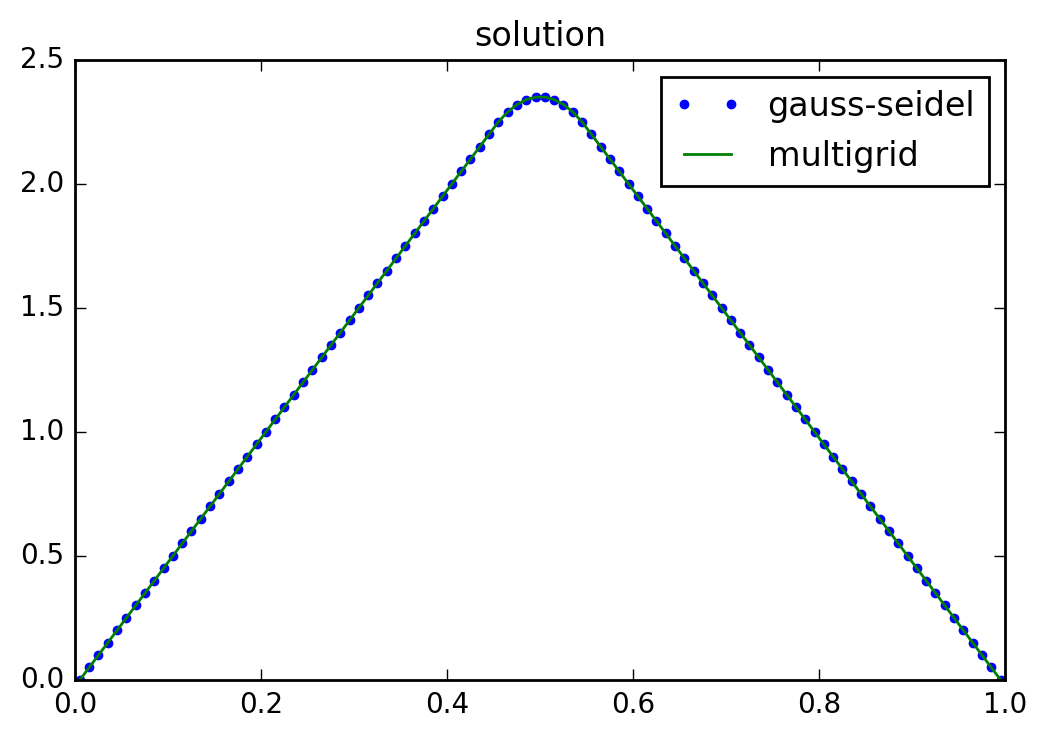

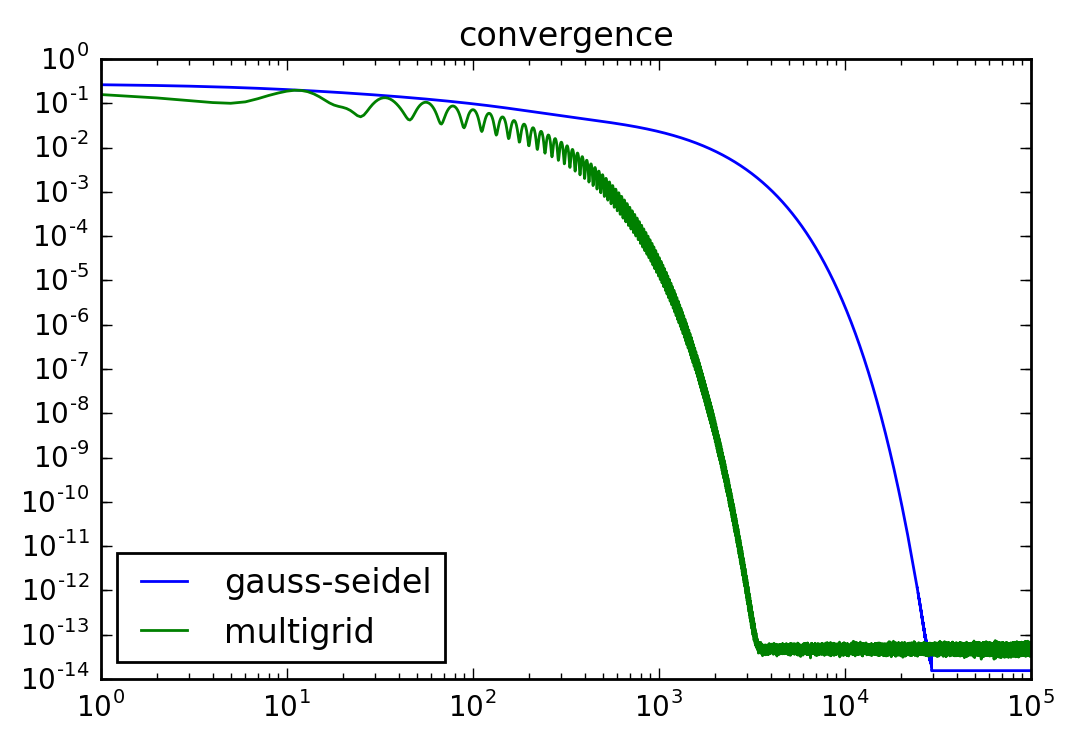

In [9]:
N = 100000 # number of iterations 
res = 100 # grid resolution

# run both methods --------------
(domain, phi_gs, RMS_gs) = diffusion_1d_gs(res, N)
(domain, phi_mg, RMS_mg) = diffusion_1d_mg(res, N)

#plot results --------------

# solution
plt.figure()
ax = plt.gca()
plt.plot(domain, phi_gs, label="gauss-seidel", linestyle = ' ', marker='.')
plt.plot(domain, phi_mg, label="multigrid")
plt.title("solution")
plt.legend(loc='best')
plt.draw()

# convergence
plt.figure()
ax = plt.gca()
plt.loglog(np.linspace(0, N, N, False), RMS_gs, label="gauss-seidel")
plt.loglog(np.linspace(0, N, N, False), RMS_mg, label="multigrid")
plt.title("convergence")
plt.legend(loc='best')
plt.draw()
plt.show()

### Discussion
* **Results**

    The solutions from both methods match perfectly indicating a correct solution. In addition we see that multi-grid method converges in fewer iterations than standard Gauss-Seidel (note that this is not an equal-time comparison here). However, the multigrid convergence is not as impressive as expected. The reason is probably the fact, that we used a very small grid resolution for this run. Higher grid resolution most likely will make the difference more prominent.
    

* **Vectorization**

    What is missing is the use of vectorization. Currently we iterate over all cells in python which is probably slow. This needs to be turned into vectorized form. However, when expressing gauss-seidel in matrix form $Ax=b$, we do not exploit the sparsity of $A$ anymore. I am not sure that switching to vectorization with dense matrix vector dot products will be faster.


* **Oscillation in the convergence plot**

    The convergence plot of the multigrid method has some strange oscillating patterns. After some investigations, I get the impression that those are caused by the dirichlet boundary conditions which produce some numerical effects near the boundary. Maybe this needs to be investigated further. A related question would be how boundary conditions on the fine mesh transfer to the coarse mesh.